In [26]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
import cartopy.feature as cfeature

In [2]:
path = '/scratch/averstyn/'
file = 'pdo.data'
index_name = 'pdo'

df=pd.read_table(path+file,skiprows=1,
                 header=None,delim_whitespace=True,
                 index_col=0,parse_dates=True,
                 na_values=['-99.9','-99.90'])
df.drop(df.tail(3).index,inplace=True)

In [3]:
start_date=str(df.index[0])+'-'+str(df.columns[0])+'-01'
end_date=str(df.index[-8])+'-'+str(df.columns[-1])+'-01'
print(end_date)

2022-12-01


In [4]:
dates=pd.date_range(start=start_date,end=end_date,freq='MS')
dates

DatetimeIndex(['1948-01-01', '1948-02-01', '1948-03-01', '1948-04-01',
               '1948-05-01', '1948-06-01', '1948-07-01', '1948-08-01',
               '1948-09-01', '1948-10-01',
               ...
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01',
               '2022-11-01', '2022-12-01'],
              dtype='datetime64[ns]', length=900, freq='MS')

In [5]:
clim_index=df.T.unstack().values
clim_index[-20:]=np.nan
clim_index = clim_index[:900]
clim_index=clim_index.astype('float32')

In [6]:
ds_index=xr.DataArray(clim_index,
                      coords={'time':dates},
                              dims=['time'])        
ds_index=ds_index.to_dataset(name='pdo')
ds_index

<xarray.Dataset>
Dimensions:  (time: 900)
Coordinates:
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2022-12-01
Data variables:
    pdo      (time) float32 -0.11 -0.74 -0.03 -1.33 ... -9.9 -9.9 -9.9 -9.9

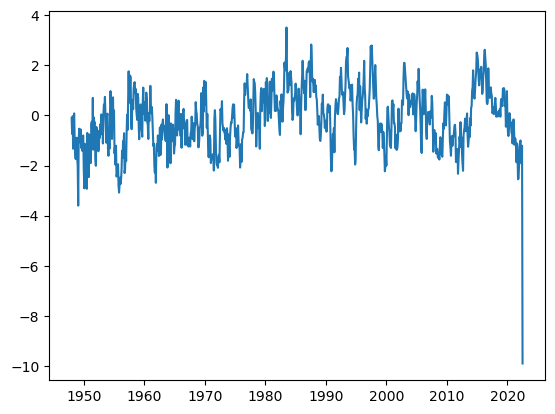

In [7]:
plt.plot(ds_index['time'][:-5],ds_index['pdo'][:-5])

In [8]:
s5p_ds = xr.open_mfdataset('/home/averstyn/final_s5p/*.nc')

In [9]:
pospdo = ds_index.where(ds_index>=0)
negpdo = ds_index.where(ds_index<=0)

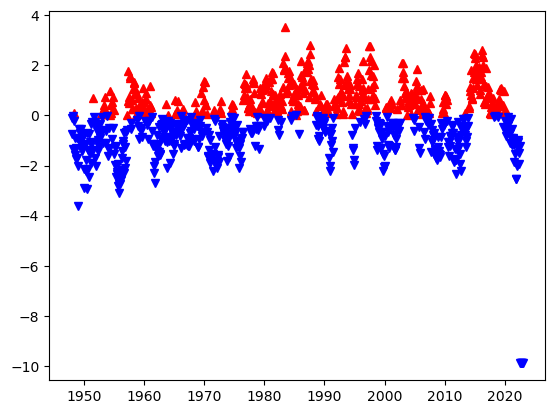

In [10]:
plt.plot(ds_index['time'],pospdo['pdo'],'r^')
plt.plot(ds_index['time'],negpdo['pdo'],'bv')

In [11]:
da_pdo = ds_index.where(ds_index.time.isin(s5p_ds.time),drop=True)
da_pdo

<xarray.Dataset>
Dimensions:  (time: 9)
Coordinates:
  * time     (time) datetime64[ns] 2019-10-01 2020-07-01 ... 2021-10-01
Data variables:
    pdo      (time) float32 -0.45 -0.38 -0.28 -0.7 -0.69 -1.87 -1.12 -1.53 -2.55

In [12]:
pospdo_g = da_pdo.where(da_pdo>=0)
negpdo_g = da_pdo.where(da_pdo<0)

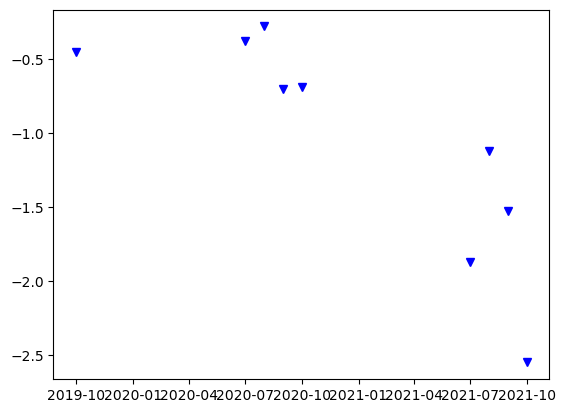

In [13]:
plt.plot(pospdo_g['time'],pospdo_g['pdo'],'r^')
plt.plot(negpdo_g['time'],negpdo_g['pdo'],'bv')

In [14]:
print('Positive: ',pospdo_g.count(dim='time').values)
print('Negative: ',negpdo_g.count(dim='time').values)
counts=[pospdo_g.count(dim='time').values,
        negpdo_g.count(dim='time').values]
print(counts)

Positive:  <bound method Mapping.values of <xarray.Dataset>
Dimensions:  ()
Data variables:
    pdo      int64 0>
Negative:  <bound method Mapping.values of <xarray.Dataset>
Dimensions:  ()
Data variables:
    pdo      int64 9>
[<bound method Mapping.values of <xarray.Dataset>
Dimensions:  ()
Data variables:
    pdo      int64 0>, <bound method Mapping.values of <xarray.Dataset>
Dimensions:  ()
Data variables:
    pdo      int64 9>]


In [15]:
da_pdo

<xarray.Dataset>
Dimensions:  (time: 9)
Coordinates:
  * time     (time) datetime64[ns] 2019-10-01 2020-07-01 ... 2021-10-01
Data variables:
    pdo      (time) float32 -0.45 -0.38 -0.28 -0.7 -0.69 -1.87 -1.12 -1.53 -2.55

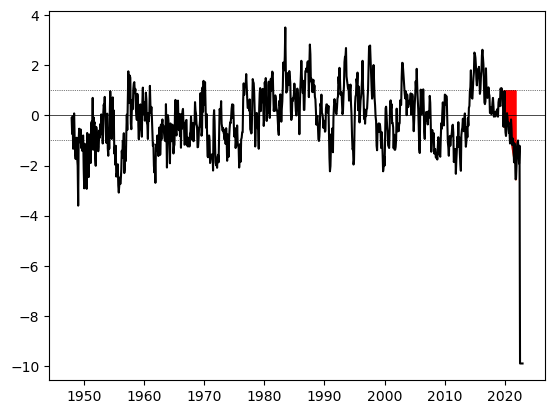

In [16]:
plt.plot(ds_index['time'],ds_index['pdo'],'k')
plt.fill_between(da_pdo['time'].values,da_pdo['pdo'],color='lightgreen')
plt.fill_between(da_pdo['time'].values,negpdo_g['pdo'],y2=1.0,color='red')
plt.fill_between(da_pdo['time'].values,pospdo_g['pdo'],y2=-1.0,color='blue')
plt.axhline(0,color='black',linewidth=0.5)
plt.axhline(1,color='black',linewidth=0.5,linestyle='dotted')
plt.axhline(-1,color='black',linewidth=0.5,linestyle='dotted') ;

In [17]:
ds_climo = s5p_ds.groupby('time.month').mean()
ds_anoms = s5p_ds.groupby('time.month') - ds_climo
ds_anoms

<xarray.Dataset>
Dimensions:                              (time: 329, lat: 361, lon: 3601)
Coordinates:
  * time                                 (time) datetime64[ns] 2019-08-06 ......
  * lat                                  (lat) float64 -90.0 -89.5 ... 89.5 90.0
  * lon                                  (lon) float64 0.0 0.1 ... 359.9 360.0
    month                                (time) int64 8 8 8 8 8 ... 10 10 10 10
Data variables:
    nitrogendioxide_tropospheric_column  (time, lat, lon) float32 dask.array<chunksize=(1, 361, 3601), meta=np.ndarray>

In [18]:
da_no2 = s5p_ds['nitrogendioxide_tropospheric_column']

In [19]:
da_climo = da_no2.groupby('time.month').mean()
da_anoms = da_no2.groupby('time.month')-da_climo
da_anoms

<xarray.DataArray 'nitrogendioxide_tropospheric_column' (time: 329, lat: 361,
                                                         lon: 3601)>
dask.array<sub, shape=(329, 361, 3601), dtype=float32, chunksize=(1, 361, 3601), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2019-08-06 2019-08-07 ... 2021-10-31
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 0.0 0.1 0.2 0.3 0.4 ... 359.6 359.7 359.8 359.9 360.0
    month    (time) int64 8 8 8 8 8 8 8 8 8 8 ... 10 10 10 10 10 10 10 10 10 10

In [20]:
#negpdo_no2 = da_anoms.sel(time=negpdo.dropna(dim='time')['time']).mean(dim='time')
negpdo

<xarray.Dataset>
Dimensions:  (time: 900)
Coordinates:
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2022-12-01
Data variables:
    pdo      (time) float32 -0.11 -0.74 -0.03 -1.33 ... -9.9 -9.9 -9.9 -9.9

In [21]:
negpdo_no2 = da_anoms.sel(time=negpdo_g.dropna(dim='time')['time']).mean(dim='time')
pospdo_no2 = da_anoms.sel(time=pospdo_g.dropna(dim='time')['time']).mean(dim='time')

comp_no2 = [negpdo_no2,pospdo_no2]

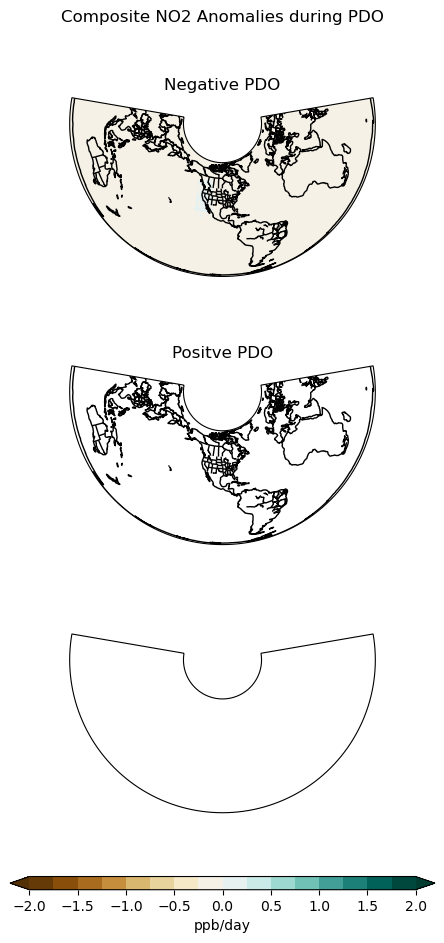

In [32]:
labels=['Negative PDO', 'Positve PDO']
clevs = np.arange(-2.0,2.1,0.25)

extent = [-120,-70,23,50]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

# Define the figure and each axis for the 3 rows and 3 columns
ax = plt.axes(projection=ccrs.AlbersEqualArea(central_lon,central_lat)

states = cfeature.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lines',scale='50m',
                             facecolor='none')

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array (just 3 rows)

#Loop over all of the seasons and plot

        # Select the season
        data = comp_no2[i]
        data_undask = data.load()

        # Add the cyclic point
        data_undask,lons = add_cyclic_point(data_undask,coord=comp_no2[i]['lon'])

        # Contour plot
        cs=axs[i].contourf(lons,comp_no2[i]['lat'],data_undask,clevs,
                          transform = ccrs.PlateCarree(),
                          cmap='BrBG',extend='both')

       # Longitude labels
        #axs[i].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
        #lon_formatter = cticker.LongitudeFormatter()
        #axs[i].xaxis.set_major_formatter(lon_formatter)

        # Latitude labels
        #axs[i].set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
        #lat_formatter = cticker.LatitudeFormatter()
        #axs[i].yaxis.set_major_formatter(lat_formatter)

        
        # Title each subplot with the name of the season
        axs[i].set_title(labels[i])

        # Draw the coastines for each subplot
        axs[i].coastlines()
        
        #Add state overlay
        axs[i].add_feature(states)
        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.5)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.25, 0.18, 0.5, 0.012])

# Draw the colorbar
cbar = fig.colorbar(cs,cax=cbar_ax,orientation='horizontal',label='ppb/day')

# Add a big title at the top
plt.suptitle('Composite NO2 Anomalies during PDO') ;

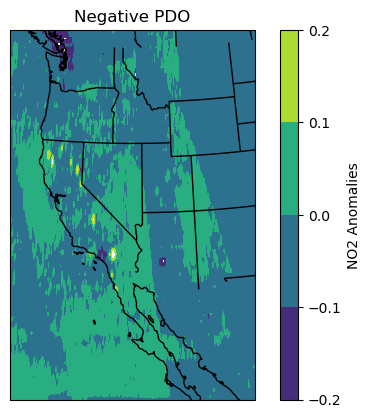

In [74]:
labels=['Negative PDO', 'Positve PDO']
#clevs = np.arange(-2.0,0,0.5)

extent = [-125,-105,23,50]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

# Define the figure and each axis for the 3 rows and 3 columns
ax = plt.axes(projection=ccrs.AlbersEqualArea(central_lon,central_lat))

states = cfeature.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lines',scale='50m',
                             facecolor='none')
              
neg_data = comp_no2[0]
neg_data = neg_data*10000

ax.set_extent(extent)

cs = ax.contourf(neg_data['lon'],neg_data['lat'],neg_data,levels=[-0.2,-0.1,0,0.1,0.2],transform=ccrs.PlateCarree())

ax.set_title('Negative PDO')

ax.coastlines()

ax.add_feature(states)

plt.colorbar(cs,label='NO2 Anomalies')


<xarray.DataArray 'nitrogendioxide_tropospheric_column' (lat: 361, lon: 3601)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 0.0 0.1 0.2 0.3 0.4 ... 359.6 359.7 359.8 359.9 360.0


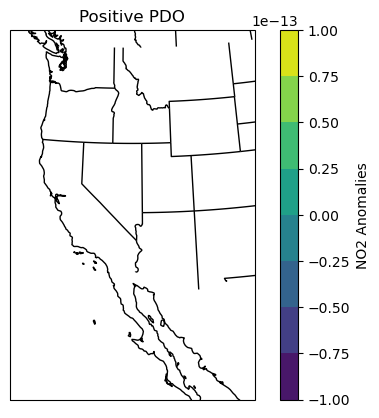

In [79]:
labels=['Negative PDO', 'Positve PDO']
#clevs = np.arange(-2.0,0,0.5)
clevs=[-0.2,-0.1,0,0.1,0.2]

extent = [-125,-105,23,50]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

# Define the figure and each axis for the 3 rows and 3 columns
ax = plt.axes(projection=ccrs.AlbersEqualArea(central_lon,central_lat))

states = cfeature.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lines',scale='50m',
                             facecolor='none')
              
pos_data = comp_no2[1]
pos_data = pos_data*100000
print(pos_data)

ax.set_extent(extent)

cs = ax.contourf(pos_data['lon'],pos_data['lat'],pos_data,transform=ccrs.PlateCarree())

ax.set_title('Positive PDO')

ax.coastlines()

ax.add_feature(states)

plt.colorbar(cs,label='NO2 Anomalies')
